<a href="https://www.kaggle.com/toygarr/sentiment-aware-model-to-classify-tweets-real-time?scriptVersionId=83029859" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment-aware Contextual Model for Tweets

Sentiment Analysis has an important role in today’s world especially for private companies
which hold lots of data. The massive amount of data generated by Twitter present a unique
opportunity for sentiment analysis. However, it is challenging to build an accurate predictive
model to identify sentiments, which may lack sufficient context due to the length limit. In
addition, sentimental and regular ones can be hard to separate because of word ambiguity. In
this notebook, I will be proposing the phases of text pre-processing, visual analysis and modeling.

***I tried to keep code as simple as possible to remain understandable.***

Proposed **BERT-CNN-BiLSTM-FC** learning pipeline, which consists of **three sequential modules**.<br />
BERT produces competitive results, and can be considered as one of the new electricity of natural
language processing tasks such as sentiment analysis, named entity recognition (NER), and topic
modeling. The combination of CNN and BiLSTM models requires a particular design, since each
model has a specific architecture and its own strengths:<br />
• BERT is utilized to transform word tokens from the raw Tweet messages to contextual word
embeddings.<br />
• CNN is known for its ability to extract as many features as possible from the text.<br />
• BiLSTM keeps the chronological order between words in a document, thus it has the ability
to ignore unnecessary words using the delete gate.<br />
• Fully Connected Layers give robustness to decrease unsteadiness of results in hard cases. 

## > If you find my work useful please don't forget to **Upvote!**  so it can reach more people.


**References:**<br />
1) [A Sentiment-Aware Contextual Model for Real-Time Disaster Prediction Using Twitter Data](https://www.mdpi.com/1999-5903/13/7/163/htm) -> The idea comes from and really worth to check on, however, i am not using the same model.<br />
2) [Automatic identification of eyewitness messages on twitter during disasters](https://reader.elsevier.com/reader/sd/pii/S0306457319303590?token=985D740724AEDB812611486EBAD3B68FA4393520D4DCD96FDADE4A642A9805D728945987C1BBBE0FDAA8EC3684E372C7&originRegion=eu-west-1&originCreation=20210920022341)<br />
3) [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/abs/1408.5882)<br />
4) [BERT: Pre-training of Deep Bidirectional Transformers for Language
               Understanding](http://arxiv.org/abs/1810.04805)<br />
5) [LMAES' Notebook](https://www.kaggle.com/lmasca/disaster-tweets-using-bert-embeddings-and-lstm)<br />
6) [PAOLO RIPAMONTI's Notebook](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

In [25]:
# few of the imports are just for checking while coding not included in the rest of notebook.

# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords


# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # not actively using
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools


# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# for build our model
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


2021-12-22 15:25:55.382243: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-22 15:25:55.382350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [26]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"

# Read Dataset

### Dataset details:
http://help.sentiment140.com the site is pretty old and most of the links are broken, however, check out for more detail.

Latest availability of dataset: https://www.kaggle.com/kazanova/sentiment140

@ONLINE {Sentiment140, <br />
    author = "Go, Alec and Bhayani, Richa and Huang, Lei", <br />
    title  = "Twitter Sentiment Classification using Distant Supervision", <br />
    year   = "2009", <br />
    url    = "http://help.sentiment140.com/home"
}

*According to the creators of the dataset:* \
"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search".


The data is a CSV with emoticons removed. Data file format has 6 fields:
* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet
* date: the date of the tweet
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted
* text: the text of the tweet

In [27]:
# Read the data
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', 
                 encoding = DATASET_ENCODING, names=DATASET_COLUMNS)

In [28]:
# Raw data
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Map target label to String
* 0 -> NEGATIVE
* 2 -> NEUTRAL
* 4 -> POSITIVE

In [29]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [30]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 709 ms, sys: 23 ms, total: 732 ms
Wall time: 734 ms


# Cleaning Text

So basically what we will do here:

* Remove urls, html tags and punctuations

In [31]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)



def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df['text_clean'] = df['text'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [32]:
df.head()

,target,ids,date,flag,user,text,text_clean
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot Awww thats a bummer You shoulda ...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


# Visualizing the Data

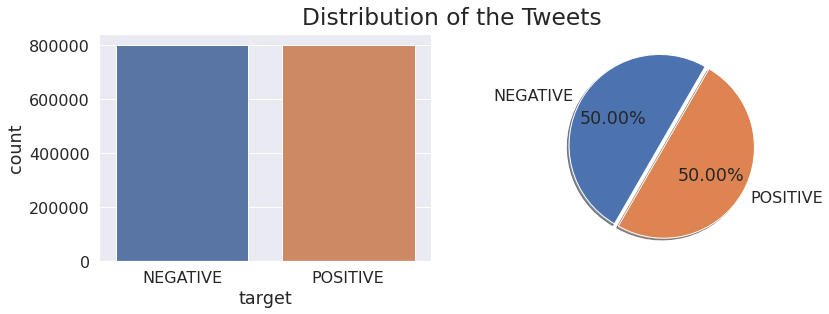

In [33]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=[NEGATIVE, POSITIVE],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

________________

As a quick and easy observation, we can say that dataset has no imbalanced label problem. Negative and Positive labels are equal. The situation of equilibrium will let model to learn more accurate. However, should not be forgotten, dataset might has lots of mislabelled text due to way of collection which has only parameter as **":)" : positive** or **":(" : negative**. The problem is that lots of user may send ":)" or ":(" ironically.  

> An example: "u look like a sh\*t today :)"

This problem may decrease the accuracy, however, end of the day we're creating a sentiment-aware model depending on the words.

_____

In [34]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df_x, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df_x.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

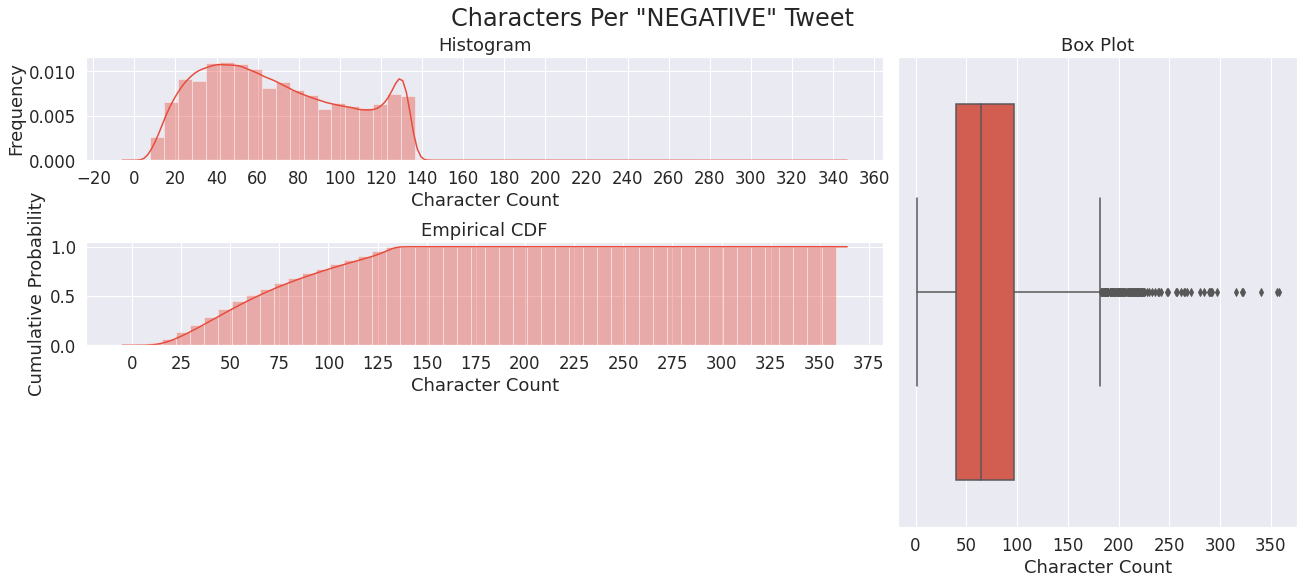

In [35]:
plot_dist3(df[df['target'] == 'NEGATIVE'], 'Character Count',
           'Characters Per "NEGATIVE" Tweet')

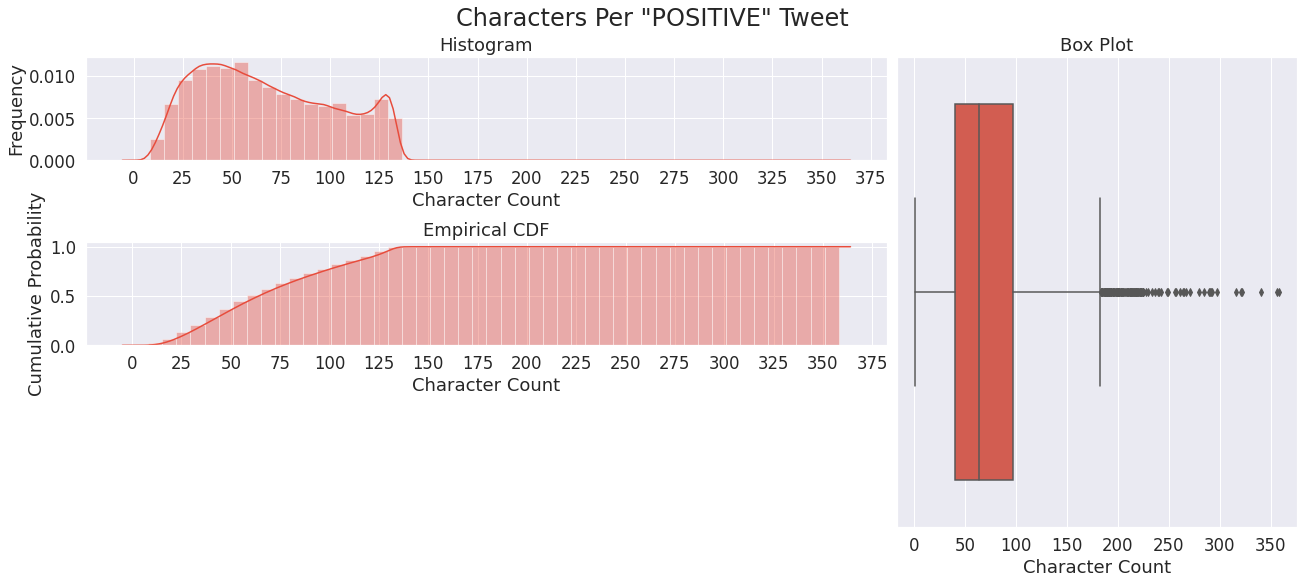

In [36]:
plot_dist3(df[df['target'] == "POSITIVE"], 'Character Count',
           'Characters Per "POSITIVE" Tweet')

# Setup environment to build model

In [37]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [38]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2021-12-22 15:27:22.989402: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-22 15:27:22.994825: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-22 15:27:22.994862: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-22 15:27:22.994937: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ad031585e94d): /proc/driver/nvidia/version does not exist
2021-12-22 15:27:22.999296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [39]:
# hyperparameters
max_length = 128
batch_size = 256

In [40]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Splitting the data

In [41]:
train_df, test = train_test_split(df, test_size=0.05, random_state=42)
train, dev = train_test_split(train_df, test_size=0.05, random_state=42)

# Label Encoder

In [42]:
labels = train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [43]:
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())
y_dev = encoder.transform(dev.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1444000, 1)
y_test (80000, 1)


In [44]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [45]:
train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

# Proposed Model

In [100]:
def bert_tweets_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]   
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_word_ids, outputs)
   
    
    return model

In [101]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 128, 768)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 126, 64)           147520    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_115 (Dropout)        (None, 256)               0   

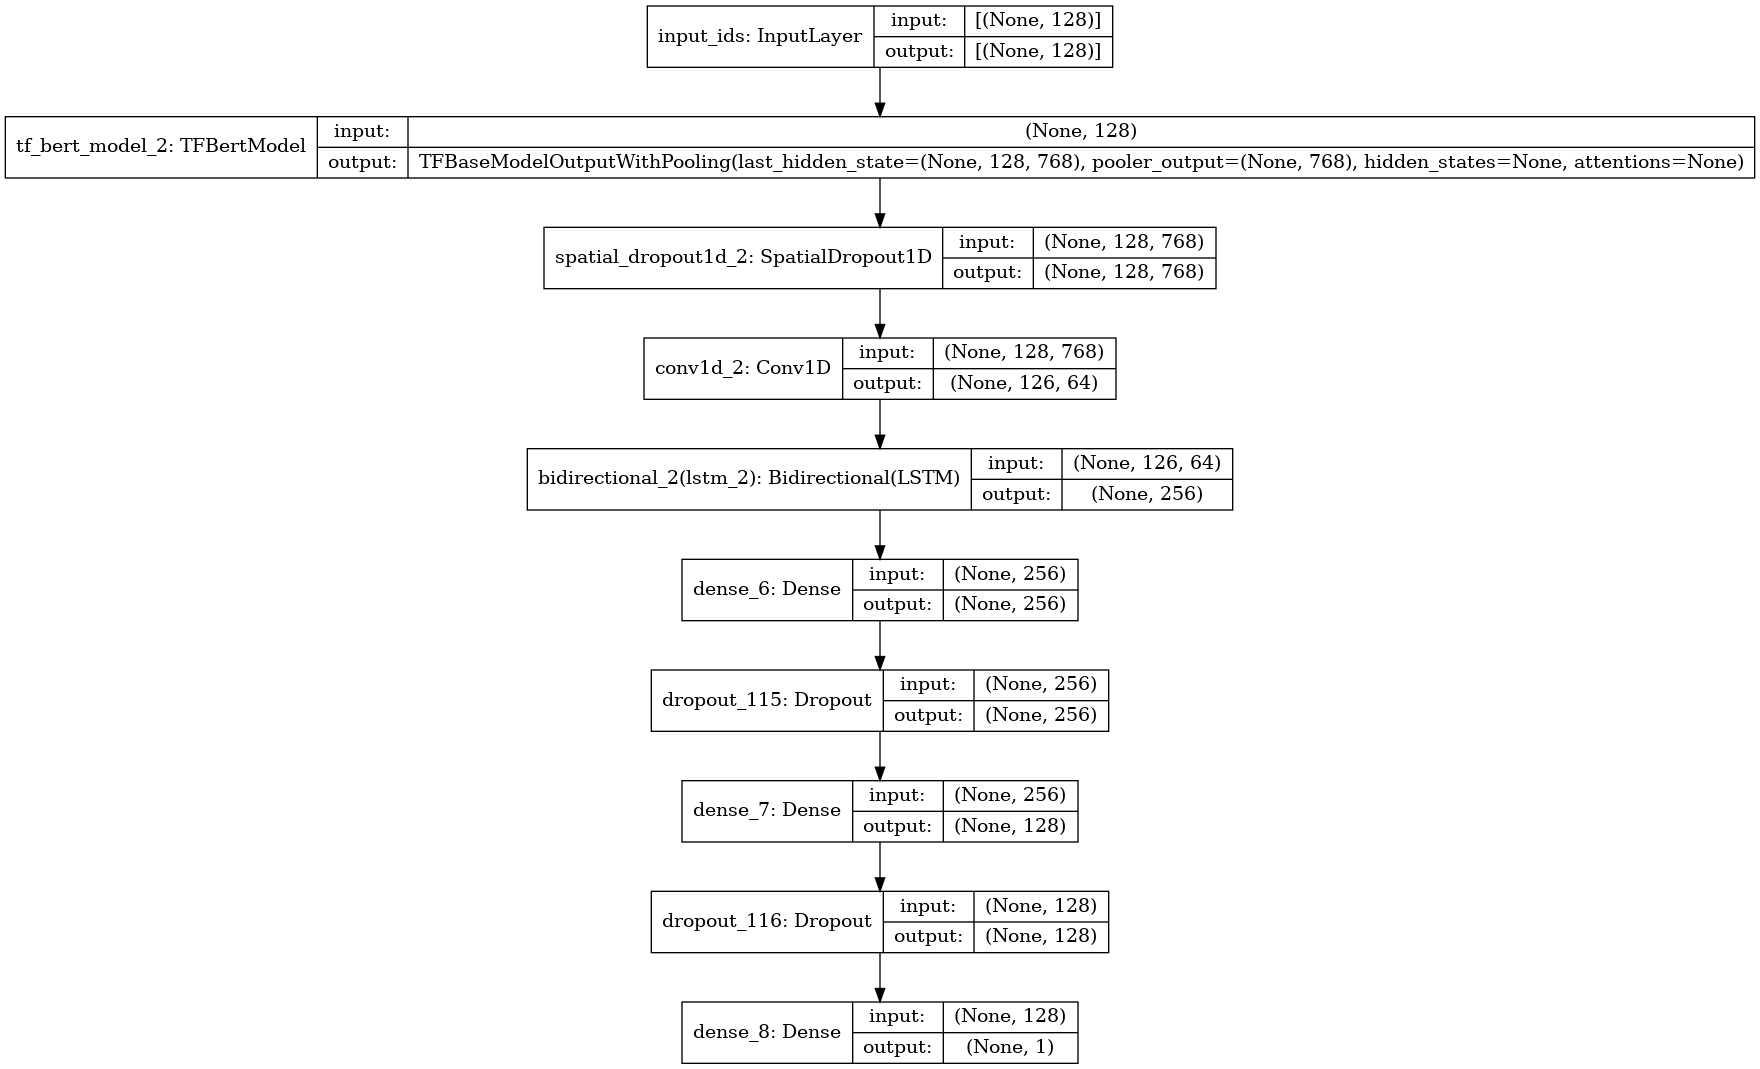

In [102]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [103]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1)
    #callbacks=[tf.keras.callbacks.EarlyStopping(
    #            patience=6,
    #            min_delta=0.05,
    #            baseline=0.7,
    #            mode='min',
    #            monitor='val_accuracy',
    #            restore_best_weights=True,
    #            verbose=1)
    #          ])

Epoch 1/3
5641/5641 [==============================] - 923s 149ms/step - loss: 0.4164 - accuracy: 0.8092 - val_loss: 0.3332 - val_accuracy: 0.8543
Epoch 2/3
5641/5641 [==============================] - 783s 139ms/step - loss: 0.3302 - accuracy: 0.8576 - val_loss: 0.3227 - val_accuracy: 0.8604
Epoch 3/3
5641/5641 [==============================] - 783s 139ms/step - loss: 0.3037 - accuracy: 0.8704 - val_loss: 0.3234 - val_accuracy: 0.8618


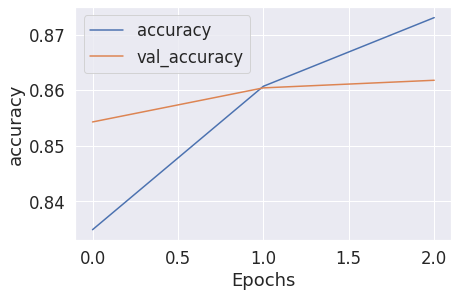

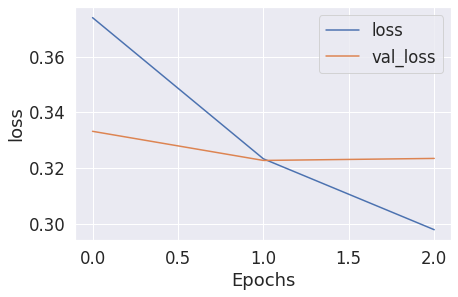

In [104]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Predict Manually Before Using Test Data

Decoder to be able to see results as labelled negative, positive or neutral

In [105]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [106]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [107]:
predict("I hate the economy")

{'label': 'NEGATIVE',
 'score': 0.006797760725021362,
 'elapsed_time': 7.975245952606201}

In [108]:
predict("I would prefer writing a crawler to create this dataset but i couldn't")

{'label': 'NEGATIVE',
 'score': 0.012284964323043823,
 'elapsed_time': 0.3806605339050293}

In [109]:
predict("I LOVE NLP")

{'label': 'POSITIVE',
 'score': 0.9634640216827393,
 'elapsed_time': 0.38303613662719727}

In [132]:
predict("life is really strange isn't it? just the combination of laugh and sadness")

{'label': 'NEUTRAL',
 'score': 0.6867418885231018,
 'elapsed_time': 0.37985682487487793}

In [111]:
predict("ESL is the world's largest esports company, leading the industry across the most popular video games.\
        We're proud they've chosen us to help them deliver their launchers to gamers all over the world. Read the full review")

{'label': 'POSITIVE',
 'score': 0.997793436050415,
 'elapsed_time': 0.3699023723602295}

In [112]:
predict("Excited to present a tutorial on 'Modular and Parameter-Efficient Fine-Tuning for NLP Models' \
        at #EMNLP2022 with @PfeiffJo & @licwu.")

{'label': 'POSITIVE',
 'score': 0.997810959815979,
 'elapsed_time': 0.3683598041534424}

In [113]:
predict("Had a song stuck in my head. Thirty seconds later I'm listening to it, thanks to the internet,\
        and Apple/YouTube Music. In the bad old days I'd browse record stores for hours in the hope that the title might jog my memory.\
        It really is a wonderful time to be alive!")

{'label': 'POSITIVE',
 'score': 0.8831438422203064,
 'elapsed_time': 0.37418341636657715}

In [114]:
predict("i don't say this lightly - hemingway's life ended by suicide. His life was actually a loss")

{'label': 'NEGATIVE',
 'score': 0.15372329950332642,
 'elapsed_time': 0.373279333114624}

In [115]:
predict("these r not ur problems dear!!! these r ur x bf's commitng suicide")

{'label': 'NEGATIVE',
 'score': 0.17633694410324097,
 'elapsed_time': 0.3759784698486328}

In [116]:
predict("i hve no idea about that i love the uni or not")

{'label': 'NEUTRAL',
 'score': 0.4587610363960266,
 'elapsed_time': 0.40152597427368164}

In [117]:
predict("Do you think Ninja's sneak up on their family members just for fun? #FunThoughts #MyBrain (@JohnLusher23)")

{'label': 'POSITIVE',
 'score': 0.8653885722160339,
 'elapsed_time': 0.3733646869659424}

In [118]:
predict("So U know when u get home and see green veggie stuff\
        stuck in ur teeth and wanna curse everybody that didn't tell u (‏@tyrabanks)")

{'label': 'POSITIVE',
 'score': 0.7275711297988892,
 'elapsed_time': 0.3741002082824707}

In [119]:
predict("For the third time in four years, the Warriors are champions once again.\
This time, they wasted no time in the NBA Finals, dispatching LeBron James and the Cavs in four straight games.\
Here’s how they sealed the championship in Game 4. https://twitter.com/i/moments/1005197277663641600")

{'label': 'POSITIVE',
 'score': 0.8274564146995544,
 'elapsed_time': 0.3800084590911865}

In [120]:
predict("I found some old Reddit post in which one guy from english-speaking country complains that\
the names in The Witcher books are 'too difficult' and non- intuitive for english speaker.\
Man, let me introduce you to 'The books werent written only/for english speakers.'' #witcher")

{'label': 'NEGATIVE',
 'score': 0.3226395845413208,
 'elapsed_time': 0.38419055938720703}

In [121]:
predict("I forgot how cringy all the Slavic names sound read it English \
YOU'RE PRONOUNCING IT ALL WRONG MY EARS ARE HURTING AND I DON'T EVEN HAVE HEARING AIDS IN")

{'label': 'NEGATIVE',
 'score': 0.20003759860992432,
 'elapsed_time': 0.426267147064209}

In [122]:
predict("fun fact: ai cannot predict everything right")

{'label': 'NEUTRAL',
 'score': 0.6593181490898132,
 'elapsed_time': 0.36420488357543945}

In [134]:
predict("brain is just a machine")

{'label': 'NEUTRAL',
 'score': 0.4809401333332062,
 'elapsed_time': 0.3757643699645996}

# Evaluate

In [124]:
test_encoded = bert_encode(test.text_clean)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

y_pred = []
predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()

In [125]:
%%time
scores = model.evaluate(test_encoded, y_test, batch_size=batch_size)
print()
print("ACCURACY:",scores[1])
print("LOSS:",scores[0])

313/313 [==============================] - 18s 58ms/step - loss: 0.3239 - accuracy: 0.8618

ACCURACY: 0.8618249893188477
LOSS: 0.3239281177520752
CPU times: user 2.32 s, sys: 418 ms, total: 2.74 s
Wall time: 18.5 s


In [126]:
y_pred = [decode_sentiment(predicted_tweets, include_neutral=False) for predicted_tweets in scores]

In [127]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

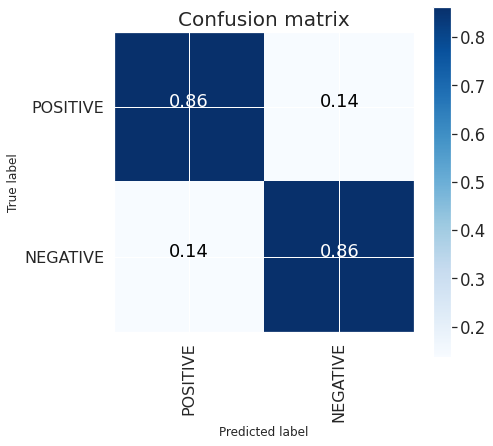

In [128]:
cnf_matrix = confusion_matrix(y_test, predicted_tweets_binary)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=train.target.unique(), title="Confusion matrix")
plt.show()

# Classification Report

In [129]:
print(classification_report(y_test, predicted_tweets_binary))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     39999
           1       0.86      0.86      0.86     40001

    accuracy                           0.86     80000
   macro avg       0.86      0.86      0.86     80000
weighted avg       0.86      0.86      0.86     80000



# Accuracy Score

In [130]:
accuracy_score(y_test, predicted_tweets_binary)

0.861825

In [ ]:
tf.keras.models.save('/tmp/model')

In [ ]:
tf.keras.model.save(KERAS_MODEL)

_____

# Fetching data from twitter
To get started, we’ll need to do the following things:

* Set up a Twitter account if you don’t have one already.
* Using the Twitter dev account, we will need to apply for Developer Access and then create an application that will generate the API credentials that you will use to access Twitter from Python.
* Import the tweepy package.

## Authorization
After installing and importing tweepy package, to access the Twitter API, we will need 4 things 
from the your Twitter App page. These keys are located in our Twitter app settings in the Keys and Access Tokens tab.
> consumer key <br />
consumer seceret key<br />
access token key<br />
access token secret key

In [ ]:
!pip install tweepy
!pip install streamlit

____ 
### Getting authorization

In [ ]:
import tweepy as tw #for accessing Twitter API
#Getting authorization
consumer_key= "X"
consumer_key_secret= "X"
access_token= "X"
access_token_secret= "X"

auth = tw.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

____

## Search Twitter for Tweets
### 1. Searching for a hashtag from a specified date
Now we are ready to search Twitter for recent tweets. We will use the **.Cursor** method to get an object containing tweets containing the hashtag #. 

To create this query, we will define the:

* Search term - in this case #yemeksepeti
* the start date of our search

In [ ]:
# Define the search term and the date_since date as variables
search_words = "#rock"
date_since = "2021-12-20"

In [ ]:
# Collect tweets
tweets = tw.Cursor(api.search_tweets,
              q=search_words,
              lang="en",
              since=date_since).items(10)

# Iterate and print tweets
for tweet in tweets:
    print(tweet.text)
    predict([tweet.text]) #predicting sentiment
    print("")

## 2. Searching for a keyword
We can pass the keyword of  interest here and the number of tweets (in this case 10) to be downloaded through the tweepy API.

In [ ]:
for tweet in api.search_tweets(q="pinkfloyd", lang="en", rpp=10):
    print(f"{tweet.user.name}:{tweet.text}")
    predict([tweet.text]) #predicting sentiment
    print("")

## 3. Searching for a username
The user_timeline() method of the API class in Tweepy module is used to get the most recent statuses posted from the authenticating user or the user specified.

* screen_name = user id name of the twitter user
* count = no. of tweets to be fetched
* lang = language of tweet
* tweet_mode = 'extended' swaps the text index for full_text, and prevents a primary tweet longer than 140 characters from being truncated. <br />

The below query pulls 10 tweets from Twitter user @ of english language and predicts its sentiments.

In [ ]:
posts = api.user_timeline(screen_name="pinkfloyd", count = 10, lang ="en", tweet_mode="extended")

l=[] 
i=1

for tweet in posts[:10]:
    l.append(tweet.full_text) 
    i=i+1
for j in range (0,9):
    print(l[j])
    predict([l[j]])  #predicting sentiment
    print("\n")